In [249]:
import numpy as np
import os
import shutil
import pandas as pd
import sys
import gzip
import nibabel as nib
from matplotlib import pyplot as plt
from scipy import stats
import copy
import re

## Import Files

In [237]:
path = '/Users/nanatang/VAserversim/m/Researchers/SerenaT/fromjapan_fullruns/'

In [254]:
reportfile = 'grand_PVS_report.csv'
report = pd.read_csv(os.path.join(path,reportfile))

reportrawfile = 'grand_PVS_report_RAW.csv'
reportraw = pd.read_csv(os.path.join(path,reportrawfile))

demofile = 'idaSearch_2_21_2024-ADNI3.csv'
demo = pd.read_csv(os.path.join(path,demofile))

imagelistfile = 'imagelist_adni3frangi_T1only.csv'
imagelist = pd.read_csv(os.path.join(path,imagelistfile))

imagelistfsdnfile = 'imagelist_adni3fsdn_T1only.csv'
imagelistfsdn = pd.read_csv(os.path.join(path,imagelistfsdnfile))

dxfile = 'dx_adni3.csv'
dx = pd.read_csv(os.path.join(path,dxfile))

## Missing subjects investigation
- why doesn't the fsdn image list match the frangi image list and which ones don't match
- which subjects that exist in the adni3_frangi list are missing years in the grand report
- any other discrepancies

Step 1: harmonize by making all the files have the same columns (at least: subject codes (just the number), Scan code (subject codes and the year),
        visit code, and image code)

In [255]:
subjcodes = []
for subj in imagelist['Code'].array:
    pattern = re.compile('\d{3}_\w_\d{4}')
    subjcodes.append(re.search(pattern,subj)[0])
imagecodes = []
for image in imagelist['Code'].array:
    pattern = re.compile('i\d*')
    imagecodes.append(re.search(pattern,image)[0])
visitcodes = []
for visit in imagelist['Code'].array:
    pattern = re.compile('y\d{2}')
    visitcodes.append(re.search(pattern,visit)[0])
imagelist.insert(1,'SubjectCodes',subjcodes)
imagelist.insert(2,'ImageCodes',imagecodes)
imagelist.insert(3,'VisitCodes',visitcodes)
#imagelist

In [256]:
subjcodes = []
for subj in imagelistfsdn['Code'].array:
    pattern = re.compile('\d{3}_\w_\d{4}')
    subjcodes.append(re.search(pattern,subj)[0])
imagecodes = []
for image in imagelistfsdn['Code'].array:
    pattern = re.compile('i\d*')
    imagecodes.append(re.search(pattern,image)[0])
visitcodes = []
for visit in imagelistfsdn['Code'].array:
    pattern = re.compile('y\d{2}')
    visitcodes.append(re.search(pattern,visit)[0])
imagelistfsdn.insert(1,'SubjectCodes',subjcodes)
imagelistfsdn.insert(2,'ImageCodes',imagecodes)
imagelistfsdn.insert(3,'VisitCodes',visitcodes)
##imagelistfsdn

In [257]:
subjcodes = []
for subj in reportraw['subjects'].array:
    pattern = re.compile('\d{3}_\w_\d{4}')
    subjcodes.append(re.search(pattern,subj)[0])
imagecodes = []
for image in reportraw['subjects'].array:
    pattern = re.compile('i\d*')
    imagecodes.append(re.search(pattern,image)[0])
visitcodes = []
for visit in reportraw['subjects'].array:
    pattern = re.compile('y\d{2}')
    visitcodes.append(re.search(pattern,visit)[0])
reportraw.insert(2,'SubjectCodes',subjcodes)
reportraw.insert(3,'ImageCodes',imagecodes)
reportraw.insert(4,'VisitCodes',visitcodes)

scancodes = 'ADNI3_' + reportraw['SubjectCodes'] + reportraw['VisitCodes']
reportraw.insert(2,'ScanCode',scancodes)
#reportraw

In [258]:
subjcodes = []
for subj in report['subjects'].array:
    pattern = re.compile('\d{3}_\w_\d{4}')
    subjcodes.append(re.search(pattern,subj)[0])
imagecodes = []
for image in report['subjects'].array:
    pattern = re.compile('i\d*')
    imagecodes.append(re.search(pattern,image)[0])
visitcodes = []
for visit in report['subjects'].array:
    pattern = re.compile('y\d{2}')
    visitcodes.append(re.search(pattern,visit)[0])
report.insert(2,'SubjectCodes',subjcodes)
report.insert(3,'ImageCodes',imagecodes)
report.insert(4,'VisitCodes',visitcodes)

scancodes = 'ADNI3_' + report['SubjectCodes'] + report['VisitCodes']
report.insert(2,'ScanCode',scancodes)
#report

Step 2: make a deep copy so you don't screw things up when you merge

In [241]:
imagelistfsdn_copy = copy.deepcopy(imagelistfsdn)
imagelist['check'] = 'yes'
imagelist

,Code,ScanCode,ImageType,ImageStore,ResearchGroup,SubjectCodes,ImageCodes,VisitCodes,check
0,ADNI3_002_S_0413y00_i863056,ADNI3_002_S_0413y00,T1,Dicom,CN,002_S_0413,i863056,y00,yes
1,ADNI3_002_S_0413y02_i1221051,ADNI3_002_S_0413y02,T1,Dicom,CN,002_S_0413,i1221051,y02,yes
2,ADNI3_002_S_1155y00_i843510,ADNI3_002_S_1155y00,T1,Dicom,MCI,002_S_1155,i843510,y00,yes
3,ADNI3_002_S_1155y01_i995496,ADNI3_002_S_1155y01,T1,Dicom,MCI,002_S_1155,i995496,y01,yes
4,ADNI3_002_S_1155y02_i1270004,ADNI3_002_S_1155y02,T1,Dicom,MCI,002_S_1155,i1270004,y02,yes
...,...,...,...,...,...,...,...,...,...
2130,ADNI3_941_S_7051y00_i1553005,ADNI3_941_S_7051y00,T1,Dicom,CN,941_S_7051,i1553005,y00,yes
2131,ADNI3_941_S_7074y00_i1588331,ADNI3_941_S_7074y00,T1,Dicom,CN,941_S_7074,i1588331,y00,yes
2132,ADNI3_941_S_7085y00_i1600180,ADNI3_941_S_7085y00,T1,Dicom,MCI,941_S_7085,i1600180,y00,yes
2133,ADNI3_941_S_7087y00_i1591321,ADNI3_941_S_7087y00,T1,Dicom,CN,941_S_7087,i1591321,y00,yes


In [261]:
imagelistcopy = copy.deepcopy(imagelist)
reportcopy = copy.deepcopy(report)
reportcopy.drop_duplicates('subjects',inplace=True)    
imagelistcopy                 

,Code,SubjectCodes,ImageCodes,VisitCodes,ScanCode,ImageType,ImageStore,ResearchGroup
0,ADNI3_002_S_0413y00_i863056,002_S_0413,i863056,y00,ADNI3_002_S_0413y00,T1,Dicom,CN
1,ADNI3_002_S_0413y02_i1221051,002_S_0413,i1221051,y02,ADNI3_002_S_0413y02,T1,Dicom,CN
2,ADNI3_002_S_1155y00_i843510,002_S_1155,i843510,y00,ADNI3_002_S_1155y00,T1,Dicom,MCI
3,ADNI3_002_S_1155y01_i995496,002_S_1155,i995496,y01,ADNI3_002_S_1155y01,T1,Dicom,MCI
4,ADNI3_002_S_1155y02_i1270004,002_S_1155,i1270004,y02,ADNI3_002_S_1155y02,T1,Dicom,MCI
...,...,...,...,...,...,...,...,...
2130,ADNI3_941_S_7051y00_i1553005,941_S_7051,i1553005,y00,ADNI3_941_S_7051y00,T1,Dicom,CN
2131,ADNI3_941_S_7074y00_i1588331,941_S_7074,i1588331,y00,ADNI3_941_S_7074y00,T1,Dicom,CN
2132,ADNI3_941_S_7085y00_i1600180,941_S_7085,i1600180,y00,ADNI3_941_S_7085y00,T1,Dicom,MCI
2133,ADNI3_941_S_7087y00_i1591321,941_S_7087,i1591321,y00,ADNI3_941_S_7087y00,T1,Dicom,CN


Step 3: do your merging and investigating

Check which subjects are missing from the ADNI3_frangi list based on ADNI3_FSdn list

In [262]:
mergedimagelist = imagelistfsdn_copy.merge(imagelist,how='left',on='ImageCodes')

In [263]:
## this tells you which subjects are missing from ADNI3_frangi that don't match ADNI3_FSdn
## specifically, the last 3 don't match
nullmask = mergedimagelist.isnull().any(axis=1)
nullrow = mergedimagelist[nullmask]
nullrow

,Code_x,SubjectCodes_x,ImageCodes,VisitCodes_x,ScanCode_x,ImageType_x,ImageStore_x,Code_y,SubjectCodes_y,VisitCodes_y,ScanCode_y,ImageType_y,ImageStore_y,ResearchGroup
573,ADNI3_024_S_7025y00_i1515286,024_S_7025,i1515286,y00,ADNI3_024_S_7025y00,T1,Dicom,NaN,NaN,NaN,NaN,NaN,NaN,NaN
978,ADNI3_051_S_6527y00_i1043951,051_S_6527,i1043951,y00,ADNI3_051_S_6527y00,T1,Dicom,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1580,ADNI3_129_S_6482y00_i1021033,129_S_6482,i1021033,y00,ADNI3_129_S_6482y00,T1,Dicom,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993,ADNI3_305_S_6263y00_i971096,305_S_6263,i971096,y00,ADNI3_305_S_6263y00,T1,Dicom,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [264]:
nullrow.to_csv(os.path.join(path,'missingsubjects_fromimagelist.csv'))

Check which subjects are missing from the grand PVS report based on ADNI3_frangi list
- this will give you everything including those missing T1, WMH, and visit

In [247]:
imagelistreport_merge = imagelistcopy.merge(reportcopy,how='left',on='ScanCode')
imagelistreport_merge.drop_duplicates('Code',inplace=True)
imagelistreport_merge

,Code,ScanCode,ImageType,ImageStore,ResearchGroup,SubjectCodes_x,ImageCodes_x,VisitCodes_x,check,subjects,...,ImageCodes_y,VisitCodes_y,pvscount,pvsvol,icv norm,pvscountwm,pvsvolwm,icv norm wm,raw,WMH mask
0,ADNI3_002_S_0413y00_i863056,ADNI3_002_S_0413y00,T1,Dicom,CN,002_S_0413,i863056,y00,yes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ADNI3_002_S_0413y02_i1221051,ADNI3_002_S_0413y02,T1,Dicom,CN,002_S_0413,i1221051,y02,yes,ADNI3_002_S_0413y02_i1221051,...,i1221051,y02,1945.0,8300.0,0.005403,1302.0,4470.0,0.002910,no,yes
2,ADNI3_002_S_1155y00_i843510,ADNI3_002_S_1155y00,T1,Dicom,MCI,002_S_1155,i843510,y00,yes,ADNI3_002_S_1155y00_i843510,...,i843510,y00,738.0,3356.0,0.002123,210.0,660.0,0.000418,no,yes
3,ADNI3_002_S_1155y01_i995496,ADNI3_002_S_1155y01,T1,Dicom,MCI,002_S_1155,i995496,y01,yes,ADNI3_002_S_1155y01_i995496,...,i995496,y01,1988.0,7332.0,0.004549,1069.0,2793.0,0.001733,no,yes
4,ADNI3_002_S_1155y02_i1270004,ADNI3_002_S_1155y02,T1,Dicom,MCI,002_S_1155,i1270004,y02,yes,ADNI3_002_S_1155y02_i1270004,...,i1270004,y02,2020.0,8060.0,0.004978,1087.0,2856.0,0.001764,no,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2138,ADNI3_941_S_7051y00_i1553005,ADNI3_941_S_7051y00,T1,Dicom,CN,941_S_7051,i1553005,y00,yes,ADNI3_941_S_7051y00_i1553005,...,i1553005,y00,2010.0,10314.0,0.006964,1403.0,6060.0,0.004092,no,yes
2139,ADNI3_941_S_7074y00_i1588331,ADNI3_941_S_7074y00,T1,Dicom,CN,941_S_7074,i1588331,y00,yes,ADNI3_941_S_7074y00_i1588331,...,i1588331,y00,1509.0,6289.0,0.004356,969.0,2831.0,0.001961,no,yes
2140,ADNI3_941_S_7085y00_i1600180,ADNI3_941_S_7085y00,T1,Dicom,MCI,941_S_7085,i1600180,y00,yes,ADNI3_941_S_7085y00_i1600180,...,i1600180,y00,1607.0,4441.0,0.003315,954.0,1890.0,0.001411,no,yes
2141,ADNI3_941_S_7087y00_i1591321,ADNI3_941_S_7087y00,T1,Dicom,CN,941_S_7087,i1591321,y00,yes,ADNI3_941_S_7087y00_i1591321,...,i1591321,y00,1989.0,7926.0,0.004448,997.0,2721.0,0.001527,no,yes


In [248]:
## this tells you which ones are missing, whether due to T1 missing, or WMH missing, or missing visit code, or some other reason
nullmask = imagelistreport_merge.isnull().any(axis=1)
nullrow = imagelistreport_merge[nullmask]
nullrow

,Code,ScanCode,ImageType,ImageStore,ResearchGroup,SubjectCodes_x,ImageCodes_x,VisitCodes_x,check,subjects,...,ImageCodes_y,VisitCodes_y,pvscount,pvsvol,icv norm,pvscountwm,pvsvolwm,icv norm wm,raw,WMH mask
0,ADNI3_002_S_0413y00_i863056,ADNI3_002_S_0413y00,T1,Dicom,CN,002_S_0413,i863056,y00,yes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,ADNI3_002_S_5230y02_i1270084,ADNI3_002_S_5230y02,T1,Dicom,SMC,002_S_5230,i1270084,y02,yes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59,ADNI3_003_S_4288y04_i1498579,ADNI3_003_S_4288y04,T1,Dicom,CN,003_S_4288,i1498579,y04,yes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114,ADNI3_003_S_6959y00_i1456305,ADNI3_003_S_6959y00,T1,Dicom,CN,003_S_6959,i1456305,y00,yes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116,ADNI3_003_S_7010y00_i1495816,ADNI3_003_S_7010y00,T1,Dicom,CN,003_S_7010,i1495816,y00,yes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2114,ADNI3_941_S_6546y04_i1624954,ADNI3_941_S_6546y04,T1,Dicom,CN,941_S_6546,i1624954,y04,yes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2126,ADNI3_941_S_6580y04_i1624283,ADNI3_941_S_6580y04,T1,Dicom,CN,941_S_6580,i1624283,y04,yes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2128,ADNI3_941_S_6581y02_i1343754,ADNI3_941_S_6581y02,T1,Dicom,CN,941_S_6581,i1343754,y02,yes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2131,ADNI3_941_S_6854y01_i1428390,ADNI3_941_S_6854y01,T1,Dicom,AD,941_S_6854,i1428390,y01,yes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [234]:
nullrow.to_csv(os.path.join(path,'missingsubjectsfile.csv'))

In [ ]:
imagelistcopy = copy.deepcopy(imagelist)
reportcopy = copy.deepcopy(report)
reportcopy.drop_duplicates('subjects',inplace=True)    
reportcopy   

In [ ]:
imagelistreport_merge = imagelistcopy.merge(reportcopy,how='left',on='ScanCode')
imagelistreport_merge.drop_duplicates('Code',inplace=True)
imagelistreport_merge

In [ ]:
## this tells you which ones are missing, whether due to T1 missing, or WMH missing, or missing visit code, or some other reason
nullmask = imagelistreport_merge.isnull().any(axis=1)
nullrow = imagelistreport_merge[nullmask]
nullrow

## Data cleaning
Includes:
- Attaching demographics info (Age, Sex, Weight) to PVS report with 'demofile'
- Fill in correct research group for subjects in the PVS report with 'dxadni3_file'
- Figure out what years are missing for each subject that exists in the PVS report & why
- Function to clean out those that don't have WMH (optional)
- Remove outliers (really bad ones)

In [65]:
# Convert Visit Code to visit number to match report
demo_clean = demo.replace(to_replace=r'ADNI3 Initial Visit-Cont Pt', value='y00', regex=True)
demo_clean = demo_clean.replace(to_replace=r'ADNI Screening', value='y00', regex=True)
demo_clean = demo_clean.replace(to_replace=r'ADNI3 Year 1 Visit', value='y01', regex=True)
demo_clean = demo_clean.replace(to_replace=r'ADNI3 Year 2 Visit', value='y02', regex=True)
demo_clean = demo_clean.replace(to_replace=r'ADNI3 Year 3 Visit', value='y03', regex=True)
demo_clean = demo_clean.replace(to_replace=r'ADNI3 Year 4 Visit', value='y04', regex=True)
demo_clean = demo_clean.replace(to_replace=r'ADNI3 Year 5 Visit', value='y05', regex=True)
demo_clean['Phase'] = demo_clean['Phase'].replace(to_replace=r'ADNI 3', value='ADNI3', regex=True)

# add year, phase, visit and Image ID to subject ID
subjectfullid = demo_clean['Phase']+ '_' + demo_clean['Subject ID'] + demo_clean['Visit'] + '_i' + demo_clean['Image ID'].apply(str)
demo_clean.insert(1,'subjects',subjectfullid)
demo_clean = demo_clean.rename(columns={'Subject ID': 'SubjectCodes'})
demo_clean
#demo_clean['Subject ID'][demo_clean['Subject ID'] == 'ADNI3_003_S_1122y01_i909791']

,SubjectCodes,subjects,Phase,Sex,Weight,Research Group,APOE A1,APOE A2,Visit,Study Date,...,Age,Global CDR,NPI-Q Total Score,MMSE Total Score,GDSCALE Total Score,FAQ Total Score,Modality,Description,Imaging Protocol,Image ID
0,022_S_2379,ADNI3_022_S_2379y02_i1173479,ADNI3,M,96.9,EMCI,3.0,3.0,y02,6/5/19,...,74.1,NaN,NaN,NaN,NaN,NaN,MRI,Accelerated Sagittal MPRAGE,Acquisition Plane=SAGITTAL;Slice Thickness=1.0...,1173479
1,082_S_5278,ADNI3_082_S_5278y02_i1416036,ADNI3,M,73.0,SMC,3.0,4.0,y02,3/5/20,...,86.8,NaN,NaN,NaN,NaN,NaN,MRI,Accelerated Sagittal MPRAGE,Acquisition Plane=SAGITTAL;Slice Thickness=1.0...,1416036
2,082_S_6629,ADNI3_082_S_6629y02_i1559412,ADNI3,F,72.6,CN,NaN,NaN,y02,1/25/22,...,60.2,NaN,NaN,NaN,NaN,NaN,MRI,Accelerated Sagittal MPRAGE,Acquisition Plane=SAGITTAL;Slice Thickness=1.0...,1559412
3,003_S_1122,ADNI3_003_S_1122y01_i1083056,ADNI3,F,55.3,MCI,3.0,3.0,y01,12/6/18,...,88.7,NaN,NaN,NaN,NaN,NaN,MRI,Accelerated Sagittal MPRAGE,Acquisition Plane=SAGITTAL;Slice Thickness=1.0...,1083056
4,006_S_6252,ADNI3_006_S_6252y01_i1162268,ADNI3,F,81.0,MCI,3.0,4.0,y01,5/6/19,...,75.8,NaN,NaN,NaN,NaN,NaN,MRI,Axial Field Mapping,Acquisition Plane=AXIAL;Slice Thickness=3.0;Ma...,1162268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11943,941_S_7085,ADNI3_941_S_7085y00_i1600186,ADNI3,F,100.2,MCI,NaN,NaN,y00,7/1/22,...,69.7,NaN,NaN,NaN,NaN,NaN,MRI,Field Mapping,Acquisition Plane=AXIAL;Slice Thickness=3.0;Ma...,1600186
11944,941_S_7087,ADNI3_941_S_7087y00_i1591321,ADNI3,M,84.4,CN,NaN,NaN,y00,6/15/22,...,66.9,NaN,NaN,NaN,NaN,NaN,MRI,Accelerated Sagittal MPRAGE,Acquisition Plane=SAGITTAL;Slice Thickness=1.0...,1591321
11945,941_S_7087,ADNI3_941_S_7087y00_i1591327,ADNI3,M,84.4,CN,NaN,NaN,y00,6/15/22,...,66.9,NaN,NaN,NaN,NaN,NaN,MRI,Field Mapping,Acquisition Plane=AXIAL;Slice Thickness=3.0;Ma...,1591327
11946,941_S_7106,ADNI3_941_S_7106y00_i1619403,ADNI3,F,77.1,MCI,NaN,NaN,y00,9/9/22,...,71.5,NaN,NaN,NaN,NaN,NaN,MRI,Accelerated Sagittal MPRAGE,Acquisition Plane=SAGITTAL;Slice Thickness=1.0...,1619403


In [66]:
demo_clean.to_csv(os.path.join(path,'demographics_report_.csv'), index=False)

In [75]:
## test: which ones don't match?
demoonly_clean = pd.DataFrame({'subjects':demo_clean['subjects'],'SubjectCodes':demo_clean['SubjectCodes'],'Visit':demo_clean['Visit'],'Age':demo_clean['Age'],'Weight':demo_clean['Weight'],'Sex':demo_clean['Sex']})
demoonly_clean.groupby('subjects').count()
#report
#report_nomatch = copy.deepcopy(report)

# find the subjects that exist on the grand report

# group by? 
# figure out which years are missing

# report_nomatch = report_nomatch.merge(demoonly_clean,how='outer',on='subjects')
# report_nomatch.drop_duplicates(inplace=True)
# report_nomatch = report_nomatch.reset_index(drop=True)
# null_nomatch = report_nomatch[report_nomatch['research group'].isnull()].index
# report_nomatch.loc[null_nomatch]




,SubjectCodes,Visit,Age,Weight,Sex
subjects,,,,,
ADNI3_002_S_0413y00_i863056,1,1,1,1,1
ADNI3_002_S_0413y00_i863059,1,1,1,1,1
ADNI3_002_S_0413y02_i1221051,1,1,1,1,1
ADNI3_002_S_0413y02_i1221057,1,1,1,1,1
ADNI3_002_S_1155y00_i843510,1,1,1,1,1
...,...,...,...,...,...
ADNI3_941_S_7085y00_i1600186,1,1,1,1,1
ADNI3_941_S_7087y00_i1591321,1,1,1,1,1
ADNI3_941_S_7087y00_i1591327,1,1,1,1,1


In [ ]:
report_nomatch.to_csv(os.path.join(path,'report_nomatch.csv'), index=False)

In [382]:
# add age, weight, sex columns
# RUNNING THIS CELL MORE THAN ONCE WILL PRODUCE ISSUES

demoonly_clean = pd.DataFrame({'subjects':demo_clean['subjects'],'Visit':demo_clean['Visit'],'Age':demo_clean['Age'],'Weight':demo_clean['Weight'],'Sex':demo_clean['Sex']})
#report
reporttemp = copy.deepcopy(report)
reporttemp = reporttemp.merge(demoonly_clean,how='left',on='subjects')
reporttemp.drop_duplicates(inplace=True)
reporttemp = reporttemp.reset_index(drop=True)


In [383]:
reporttemp = reporttemp.iloc[:,[0,1,10,11,12,13,2,3,4,5,6,7,8,9]]
reporttemp

,subjects,research group,Visit,Age,Weight,Sex,pvscount,pvsvol,icv norm,pvscountwm,pvsvolwm,icv norm wm,raw,WMH mask
0,ADNI3_114_S_2392y00_i909791,EMCI,y00,70.6,65.8,F,2850.0,7825.0,0.005079,1987.0,4381.0,0.002844,no,yes
1,ADNI3_114_S_4404y00_i949873,EMCI,y00,88.6,79.4,F,2388.0,6859.0,0.005548,1610.0,3250.0,0.002629,no,yes
2,ADNI3_128_S_4742y00_i1039209,EMCI,y00,76.8,49.9,F,2303.0,12018.0,0.007751,1500.0,6803.0,0.004388,no,yes
3,ADNI3_027_S_4919y04_i1398602,EMCI,y04,83.2,83.3,F,2634.0,10987.0,0.008034,2047.0,6955.0,0.005086,no,yes
4,ADNI3_067_S_2304y02_i1215232,EMCI,y02,69.8,81.6,M,1608.0,6317.0,0.003594,900.0,2724.0,0.001550,no,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023,ADNI3_941_S_7074y00_i1588331,CN,y00,70.9,80.3,M,1509.0,6289.0,0.004356,969.0,2831.0,0.001961,no,yes
2024,ADNI3_941_S_7085y00_i1600180,MCI,y00,69.7,100.2,F,1607.0,4441.0,0.003315,954.0,1890.0,0.001411,no,yes
2025,ADNI3_941_S_7051y00_i1553005,CN,y00,63.7,72.6,M,2010.0,10314.0,0.006964,1403.0,6060.0,0.004092,no,yes
2026,ADNI3_941_S_7087y00_i1591321,CN,y00,66.9,84.4,M,1989.0,7926.0,0.004448,997.0,2721.0,0.001527,no,yes


In [384]:
# fix the NaN values
# some of these subjects have the wrong image ID or the wrong year labeled
# keeping the report labels because they presumably match the logs in the VA

nullind = reporttemp[reporttemp['Sex'].isnull()].index
print(nullind)

sex = pd.Series(['M','M','F','F','F'])
age = pd.Series([74.1,86.8,60.2,88.7,75.8])
weight = pd.Series([96.9,73,72.6,55.3,81])
visit = pd.Series(['y01','y01','y02','y01','y01'])

sex_all = reporttemp['Sex']
sex_all[nullind] = sex
reporttemp['Sex'] = sex_all

age_all = reporttemp['Age']
age_all[nullind] = age
reporttemp['Age'] = age_all

weight_all = reporttemp['Weight']
weight_all[nullind] = weight
reporttemp['Weight'] = weight_all

visit_all = reporttemp['Visit']
visit_all[nullind] = visit
reporttemp['Visit'] = visit_all

print(reporttemp.loc[nullind,:])


Index([162, 386, 1027, 1630, 1633], dtype='int64')
                          subjects research group Visit   Age  Weight Sex  \
162   ADNI3_022_S_2379y01_i1173479           EMCI   y01  74.1    96.9   M   
386   ADNI3_082_S_5278y01_i1416036            SMC   y01  86.8    73.0   M   
1027  ADNI3_082_S_6629y02_i1516245             CN   y02  60.2    72.6   F   
1630  ADNI3_003_S_1122y01_i1020423            MCI   y01  88.7    55.3   F   
1633  ADNI3_006_S_6252y01_i1248434            MCI   y01  75.8    81.0   F   

      pvscount   pvsvol  icv norm  pvscountwm  pvsvolwm  icv norm wm raw  \
162     2775.0   8135.0  0.005011      1808.0    3551.0     0.002187  no   
386     3330.0  12009.0  0.008365      2384.0    7714.0     0.005374  no   
1027    1002.0   4264.0  0.003306       349.0     985.0     0.000764  no   
1630     830.0   4256.0  0.003699       469.0    1628.0     0.001415  no   
1633     396.0   2896.0  0.001926       151.0     507.0     0.000337  no   

     WMH mask  
162       yes

/var/folders/1b/13y0jzbx0r7d3rjhqvq1dwd80000gn/T/ipykernel_8206/3502197589.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_all[nullind] = age
/var/folders/1b/13y0jzbx0r7d3rjhqvq1dwd80000gn/T/ipykernel_8206/3502197589.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weight_all[nullind] = weight
/var/folders/1b/13y0jzbx0r7d3rjhqvq1dwd80000gn/T/ipykernel_8206/3502197589.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vis

In [385]:
# convert Visit to visit year in number

visityear = []
for v in reporttemp['Visit'].array:
    pattern = re.compile('\d+')
    num = int(re.search(pattern,v)[0])
    visityear.append(num)

reporttemp['VisitYear'] = visityear
reporttemp

,subjects,research group,Visit,Age,Weight,Sex,pvscount,pvsvol,icv norm,pvscountwm,pvsvolwm,icv norm wm,raw,WMH mask,VisitYear
0,ADNI3_114_S_2392y00_i909791,EMCI,y00,70.6,65.8,F,2850.0,7825.0,0.005079,1987.0,4381.0,0.002844,no,yes,0
1,ADNI3_114_S_4404y00_i949873,EMCI,y00,88.6,79.4,F,2388.0,6859.0,0.005548,1610.0,3250.0,0.002629,no,yes,0
2,ADNI3_128_S_4742y00_i1039209,EMCI,y00,76.8,49.9,F,2303.0,12018.0,0.007751,1500.0,6803.0,0.004388,no,yes,0
3,ADNI3_027_S_4919y04_i1398602,EMCI,y04,83.2,83.3,F,2634.0,10987.0,0.008034,2047.0,6955.0,0.005086,no,yes,4
4,ADNI3_067_S_2304y02_i1215232,EMCI,y02,69.8,81.6,M,1608.0,6317.0,0.003594,900.0,2724.0,0.001550,no,yes,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023,ADNI3_941_S_7074y00_i1588331,CN,y00,70.9,80.3,M,1509.0,6289.0,0.004356,969.0,2831.0,0.001961,no,yes,0
2024,ADNI3_941_S_7085y00_i1600180,MCI,y00,69.7,100.2,F,1607.0,4441.0,0.003315,954.0,1890.0,0.001411,no,yes,0
2025,ADNI3_941_S_7051y00_i1553005,CN,y00,63.7,72.6,M,2010.0,10314.0,0.006964,1403.0,6060.0,0.004092,no,yes,0
2026,ADNI3_941_S_7087y00_i1591321,CN,y00,66.9,84.4,M,1989.0,7926.0,0.004448,997.0,2721.0,0.001527,no,yes,0


In [387]:
report = copy.deepcopy(reporttemp)

In [431]:
# step 1: fix all MCI labels
report_clean = report.replace(to_replace=r'.*MC.*', value='MCI', regex=True)
report_clean

,subjects,SubjectCodes,research group,Visit,Age,Weight,Sex,pvscount,pvsvol,icv norm,pvscountwm,pvsvolwm,icv norm wm,raw,WMH mask,VisitYear
0,ADNI3_114_S_2392y00_i909791,114_S_2392,MCI,y00,70.6,65.8,F,2850.0,7825.0,0.005079,1987.0,4381.0,0.002844,no,yes,0
1,ADNI3_114_S_4404y00_i949873,114_S_4404,MCI,y00,88.6,79.4,F,2388.0,6859.0,0.005548,1610.0,3250.0,0.002629,no,yes,0
2,ADNI3_128_S_4742y00_i1039209,128_S_4742,MCI,y00,76.8,49.9,F,2303.0,12018.0,0.007751,1500.0,6803.0,0.004388,no,yes,0
3,ADNI3_027_S_4919y04_i1398602,027_S_4919,MCI,y04,83.2,83.3,F,2634.0,10987.0,0.008034,2047.0,6955.0,0.005086,no,yes,4
4,ADNI3_067_S_2304y02_i1215232,067_S_2304,MCI,y02,69.8,81.6,M,1608.0,6317.0,0.003594,900.0,2724.0,0.001550,no,yes,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023,ADNI3_941_S_7074y00_i1588331,941_S_7074,CN,y00,70.9,80.3,M,1509.0,6289.0,0.004356,969.0,2831.0,0.001961,no,yes,0
2024,ADNI3_941_S_7085y00_i1600180,941_S_7085,MCI,y00,69.7,100.2,F,1607.0,4441.0,0.003315,954.0,1890.0,0.001411,no,yes,0
2025,ADNI3_941_S_7051y00_i1553005,941_S_7051,CN,y00,63.7,72.6,M,2010.0,10314.0,0.006964,1403.0,6060.0,0.004092,no,yes,0
2026,ADNI3_941_S_7087y00_i1591321,941_S_7087,CN,y00,66.9,84.4,M,1989.0,7926.0,0.004448,997.0,2721.0,0.001527,no,yes,0


In [434]:
# just for ref: number of subjects
report_clean.groupby('SubjectCodes').any()

,subjects,research group,Visit,Age,Weight,Sex,pvscount,pvsvol,icv norm,pvscountwm,pvsvolwm,icv norm wm,raw,WMH mask,VisitYear
SubjectCodes,,,,,,,,,,,,,,,
002_S_0413,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
002_S_1155,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
002_S_1261,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
002_S_1280,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False
002_S_4213,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
941_S_7051,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False
941_S_7074,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False
941_S_7085,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False


In [390]:
# step 2: other cleaning:
# anything that doesn't have WMH mask

nowmh = report_clean[report_clean['WMH mask'] == 'no'].index
report_clean.drop(nowmh,inplace=True)
display(report_clean)

# group by disease stage
grouped = report_clean.groupby(['research group'])
ad = grouped.get_group('AD')
mci = grouped.get_group('MCI')
cn = grouped.get_group('CN')

# remove outliers in each group 3 std deviations on both sides)
# cnoutlier = cn[(np.abs(stats.zscore(cn['pvscount'])) > 3) 
#                | (np.abs(stats.zscore(cn['pvsvol'])) > 3) 
#                | (np.abs(stats.zscore(cn['icv norm'])) > 3)
#                | (np.abs(stats.zscore(cn['pvscountwm'])) > 3)
#                | (np.abs(stats.zscore(cn['pvsvolwm'])) > 3)
#                | (np.abs(stats.zscore(cn['icv norm wm'])) > 3)].index
# cn.drop(cnoutlier,inplace=True)

# mcioutlier = mci[(np.abs(stats.zscore(mci['pvscount'])) > 3) 
#                | (np.abs(stats.zscore(mci['pvsvol'])) > 3) 
#                | (np.abs(stats.zscore(mci['icv norm'])) > 3)
#                | (np.abs(stats.zscore(mci['pvscountwm'])) > 3)
#                | (np.abs(stats.zscore(mci['pvsvolwm'])) > 3)
#                | (np.abs(stats.zscore(mci['icv norm wm'])) > 3)].index
# mci.drop(mcioutlier,inplace=True)

# adoutlier = ad[(np.abs(stats.zscore(ad['pvscount'])) > 3) 
#                | (np.abs(stats.zscore(ad['pvsvol'])) > 3) 
#                | (np.abs(stats.zscore(ad['icv norm'])) > 3)
#                | (np.abs(stats.zscore(ad['pvscountwm'])) > 3)
#                | (np.abs(stats.zscore(ad['pvsvolwm'])) > 3)
#                | (np.abs(stats.zscore(ad['icv norm wm'])) > 3)].index
# ad.drop(adoutlier,inplace=True)


,subjects,SubjectCodes,research group,Visit,Age,Weight,Sex,pvscount,pvsvol,icv norm,pvscountwm,pvsvolwm,icv norm wm,raw,WMH mask,VisitYear
0,ADNI3_114_S_2392y00_i909791,114_S_2392,MCI,y00,70.6,65.8,F,2850.0,7825.0,0.005079,1987.0,4381.0,0.002844,no,yes,0
1,ADNI3_114_S_4404y00_i949873,114_S_4404,MCI,y00,88.6,79.4,F,2388.0,6859.0,0.005548,1610.0,3250.0,0.002629,no,yes,0
2,ADNI3_128_S_4742y00_i1039209,128_S_4742,MCI,y00,76.8,49.9,F,2303.0,12018.0,0.007751,1500.0,6803.0,0.004388,no,yes,0
3,ADNI3_027_S_4919y04_i1398602,027_S_4919,MCI,y04,83.2,83.3,F,2634.0,10987.0,0.008034,2047.0,6955.0,0.005086,no,yes,4
4,ADNI3_067_S_2304y02_i1215232,067_S_2304,MCI,y02,69.8,81.6,M,1608.0,6317.0,0.003594,900.0,2724.0,0.001550,no,yes,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023,ADNI3_941_S_7074y00_i1588331,941_S_7074,CN,y00,70.9,80.3,M,1509.0,6289.0,0.004356,969.0,2831.0,0.001961,no,yes,0
2024,ADNI3_941_S_7085y00_i1600180,941_S_7085,MCI,y00,69.7,100.2,F,1607.0,4441.0,0.003315,954.0,1890.0,0.001411,no,yes,0
2025,ADNI3_941_S_7051y00_i1553005,941_S_7051,CN,y00,63.7,72.6,M,2010.0,10314.0,0.006964,1403.0,6060.0,0.004092,no,yes,0
2026,ADNI3_941_S_7087y00_i1591321,941_S_7087,CN,y00,66.9,84.4,M,1989.0,7926.0,0.004448,997.0,2721.0,0.001527,no,yes,0


## Extract Stats -- Cross Sectional

In [436]:
# # step 1: make a new dataframe with averaged PVS values across years for each subjects
# # assumes that each subject stays in their repsective research groups

cs_report = report_clean.groupby('SubjectCodes',as_index=False).agg({'research group':'first','Age': 'mean', 'Sex': 'first', 'Weight': 'mean', 'VisitYear': 'max', \
                                                                 'pvscount': 'mean', 'pvsvol': 'mean', 'icv norm': 'mean', \
                                                               'pvscountwm': 'mean','pvsvolwm': 'mean','icv norm wm': 'mean',})
# regroup into research groups
cs_grouped = cs_report.groupby(['research group'])
ad_cs = cs_grouped.get_group('AD')
mci_cs = cs_grouped.get_group('MCI')
cn_cs = cs_grouped.get_group('CN')

cs_report


,SubjectCodes,research group,Age,Sex,Weight,VisitYear,pvscount,pvsvol,icv norm,pvscountwm,pvsvolwm,icv norm wm
0,002_S_0413,CN,89.700000,F,59.400000,2,1945.000000,8300.000000,0.005403,1302.000000,4470.000000,0.002910
1,002_S_1155,MCI,69.266667,M,68.333333,2,1582.000000,6249.333333,0.003883,788.666667,2103.000000,0.001305
2,002_S_1261,CN,82.300000,F,57.433333,2,1544.666667,7651.333333,0.005353,1193.333333,4876.333333,0.003409
3,002_S_1280,CN,80.800000,F,93.900000,0,1079.000000,6661.000000,0.004966,657.000000,2624.000000,0.001956
4,002_S_4213,CN,85.050000,F,74.850000,2,2211.500000,7173.500000,0.005023,1544.000000,4167.500000,0.002920
...,...,...,...,...,...,...,...,...,...,...,...,...
1069,941_S_7051,CN,63.700000,M,72.600000,0,2010.000000,10314.000000,0.006964,1403.000000,6060.000000,0.004092
1070,941_S_7074,CN,70.900000,M,80.300000,0,1509.000000,6289.000000,0.004356,969.000000,2831.000000,0.001961
1071,941_S_7085,MCI,69.700000,F,100.200000,0,1607.000000,4441.000000,0.003315,954.000000,1890.000000,0.001411
1072,941_S_7087,CN,66.900000,M,84.400000,0,1989.000000,7926.000000,0.004448,997.000000,2721.000000,0.001527


In [392]:
# step 2: extract global stats in each group (mean, std)
## this is done before the transform

col = ['CN', 'MCI', 'AD']
index = ['# of subjects','mean PVS count', 'std PVS count', 'mean PVS volume', 'std PVS volume', 'mean PVS volume normed', 'std PVS volume normed']

subjcounts = [str(cn_cs.count()[0]),str(mci_cs.count()[0]),str(ad_cs.count()[0])]

mean_PVS_count = [cn_cs['pvscount'].mean(), mci_cs['pvscount'].mean(), ad_cs['pvscount'].mean()]
std_PVS_count = [cn_cs['pvscount'].std(), mci_cs['pvscount'].std(), ad_cs['pvscount'].std()]

mean_PVS_vol = [cn_cs['pvsvol'].mean(), mci_cs['pvsvol'].mean(), ad_cs['pvsvol'].mean()]
std_PVS_vol = [cn_cs['pvsvol'].std(), mci_cs['pvsvol'].std(), ad_cs['pvsvol'].std()]

mean_PVS_icvnorm = [cn_cs['icv norm'].mean(), mci_cs['icv norm'].mean(), ad_cs['icv norm'].mean()]
std_PVS_icvnorm = [cn_cs['icv norm'].std(), mci_cs['icv norm'].std(), ad_cs['icv norm'].std()]

statsall = pd.DataFrame([subjcounts,mean_PVS_count,std_PVS_count,mean_PVS_vol,std_PVS_vol,mean_PVS_icvnorm,std_PVS_icvnorm],index=index,columns=col)
statsall = statsall.style.set_caption('Stats PVS All')

mean_PVS_countwm = [cn_cs['pvscountwm'].mean(), mci_cs['pvscountwm'].mean(), ad_cs['pvscountwm'].mean()]
std_PVS_countwm = [cn_cs['pvscountwm'].std(), mci_cs['pvscountwm'].std(), ad_cs['pvscountwm'].std()]

mean_PVS_volwm = [cn_cs['pvsvolwm'].mean(), mci_cs['pvsvolwm'].mean(), ad_cs['pvsvolwm'].mean()]
std_PVS_volwm = [cn_cs['pvsvolwm'].std(), mci_cs['pvsvolwm'].std(), ad_cs['pvsvolwm'].std()]

mean_PVS_icvnormwm = [cn_cs['icv norm wm'].mean(), mci_cs['icv norm wm'].mean(), ad_cs['icv norm wm'].mean()]
std_PVS_icvnormwm = [cn_cs['icv norm wm'].std(), mci_cs['icv norm wm'].std(), ad_cs['icv norm wm'].std()]

statswm = pd.DataFrame([subjcounts,mean_PVS_countwm,std_PVS_countwm,mean_PVS_volwm,std_PVS_volwm,mean_PVS_icvnormwm,std_PVS_icvnormwm],index=index,columns=col)
statswm = statswm.style.set_caption('Stats PVS WM')

statswm

,CN,MCI,AD
# of subjects,491,411,67
mean PVS count,985.607604,1066.233820,1424.318408
std PVS count,652.092275,730.329635,993.941712
mean PVS volume,3355.017651,3731.361759,4753.440299
std PVS volume,2329.942492,2722.649340,3207.450750
mean PVS volume normed,0.002306,0.002517,0.003266
std PVS volume normed,0.001608,0.001802,0.002127


In [400]:
# step 3: same number subject correction

# # same number
# cn_num = cn[0:100]
# mci_num = mci[0:100]
# ad_num = ad

# # else keep the same
cn_num = cn_cs
mci_num = mci_cs
ad_num = ad_cs

In [423]:
# step 4: since the data is not normally distributed (right skewed), we need to log transform it

# playing around with choices: pvscount	pvsvol icv norm	pvscountwm pvsvolwm	icv norm wm

# # transform for most skewed
# cn_txfm = np.log(cn_num['icv norm wm'])
# mci_txfm = np.log(mci_num['icv norm wm'])
# ad_txfm = np.log(ad_num['icv norm wm'])

# # transform for medium skewed
cn_txfm = np.sqrt(cn_num['pvsvolwm'])
mci_txfm = np.sqrt(mci_num['pvsvolwm'])
ad_txfm = np.sqrt(ad_num['pvsvolwm'])

# # no transform
# cn_txfm = cn_num['icv norm wm']
# mci_txfm = mci_num['icv norm wm']
# ad_txfm = ad_num['icv norm wm']

# step 4.5: check that the tranform actually makes it normal - shapiro-wilks test?
## seems like I can't actually get it to be normal

print(stats.shapiro(cn_txfm))
print(stats.shapiro(mci_txfm))
print(stats.shapiro(ad_txfm))

ShapiroResult(statistic=0.9771133065223694, pvalue=5.777443448096165e-07)
ShapiroResult(statistic=0.9870370626449585, pvalue=0.00100478355307132)
ShapiroResult(statistic=0.9834446907043457, pvalue=0.5144097805023193)


In [427]:
# step 5: Stats (X^2, ANOVA, Ttest, Kruskal-Wallis, Mann-Whitney U)

# ANOVA?
fvalue, apvalue = stats.f_oneway(cn_txfm, mci_txfm, ad_txfm)
print('ANOVA: ' + str(fvalue) + ', ' + str(apvalue))

#ttest?
tvalue, tpvalue = stats.ttest_ind(cn_txfm,ad_txfm)
print('T-test: ' + str(tvalue) + ', ' + str(tpvalue))

#Kruskal?
kvalue, kpvalue = stats.kruskal(cn_txfm, mci_txfm, ad_txfm)
print('Kruskal Wallis: ' + str(kvalue) + ', ' + str(kpvalue))

#MannWhitney?
mvalue, mpvalue = stats.mannwhitneyu(cn_txfm,mci_txfm)
print('Mann-Whitney U: ' + str(mvalue) + ', ' + str(mpvalue))

# bootstrap?



ANOVA: 7.35760242651288, 0.0006741044780097856
T-test: -3.8467683105367145, 0.0001335481495190145
Kruskal Wallis: 13.651793380616132, 0.001085302324936751
Mann-Whitney U: 93545.0, 0.059104287555443634


## Plot stats -- Cross Sectional

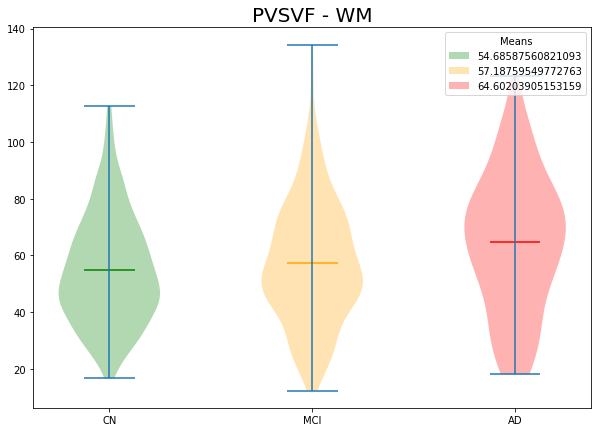

In [428]:
# step 6: plot stuff

#try: https://stackoverflow.com/questions/67376683/can-you-have-a-box-plot-overlap-a-half-violin-plot-on-a-raincloud-plot-using-pyt
#try: https://github.com/pog87/PtitPrince


## combine these different collections into a list
data_to_plot = [cn_txfm, mci_txfm, ad_txfm]

# Create a figure instance
fig = plt.figure(figsize=(10,7))

# Create the boxplot
violin = plt.violinplot(data_to_plot,positions=[1,2,3],showmeans=True,showextrema=True)

# Set the color of the violin patches
colors = ['Green', 'Orange', 'Red']
for pc, color in zip(violin['bodies'], colors):
    pc.set_facecolor(color)
violin['cmeans'].set_colors(colors)
plt.xticks([1, 2, 3], labels=['CN', 'MCI', 'AD'])
plt.legend([np.mean(cn_txfm), np.mean(mci_txfm), np.mean(ad_txfm)],title='Means')
#plt.ylim(cn_txfm.max()*-1.3,cn_txfm.max()*1.3)
plt.title('PVSVF - WM',fontsize=20)

# y, h, col = max(map(max, data_to_plot)) + 2, 2, 'k'
# plt.text(,y+h, "*", ha='center', va='bottom', color=col)

plt.show()

In [367]:
# stats comparison giant table
# need to compute: 
    # non transformed & transformed for: pvscount  pvsvol  icv norm  pvscountwm  pvsvolwm  icv norm wm
    # shapiro-wilks test for: pvscount  pvsvol  icv norm  pvscountwm  pvsvolwm  icv norm wm
    # ANOVA, ttest, kruskal wallis, mann whitney u for: cn vs ad, cn vs mci, mci vs ad for each condition above
    # means and std


    
    

In [368]:
# step n: regional stats (need to come up with a pipeline for this, not straight forward)
# should get: HP, GM / BG, CSO